## Convert Planck galaxy mask from healpix to pixell

This notebook writes one file:

 - Output file `pixell_galmask.fits`: a pixell map containing the Planck galactic mask, rotated to the ACT coordinate system.
 - 
Reference: https://github.com/alexlague/kSZquest/blob/main/prepare_mask.py

In [1]:
import kszx
import healpy
import numpy as np
import matplotlib.pyplot as plt
import pixell.reproject

In [2]:
# File 'global_params.py' in current directory
import global_params

act_dr = global_params.act_dr
sky_percentage = global_params.galmask_sky_percentage
apodization = global_params.galmask_apodization

## Some initial plots

Let's plot an ACT map, and the Planck galactic mask. In both cases the Galactic plane is clearly visible. However, it does not look the same in the two plots, since ACT uses equatorial coordinates and Planck uses Galactic. Furthermore, ACT uses pixell and Planck uses healpix.

kszx: environment variable $KSZX_DATA_DIR not defined, using /home/kmsmith/kszx_data instead
Reading /home/kmsmith/kszx_data/act/dr5.01/act_planck_dr5.01_s08s18_AA_f150_daynight_map_srcfree.fits


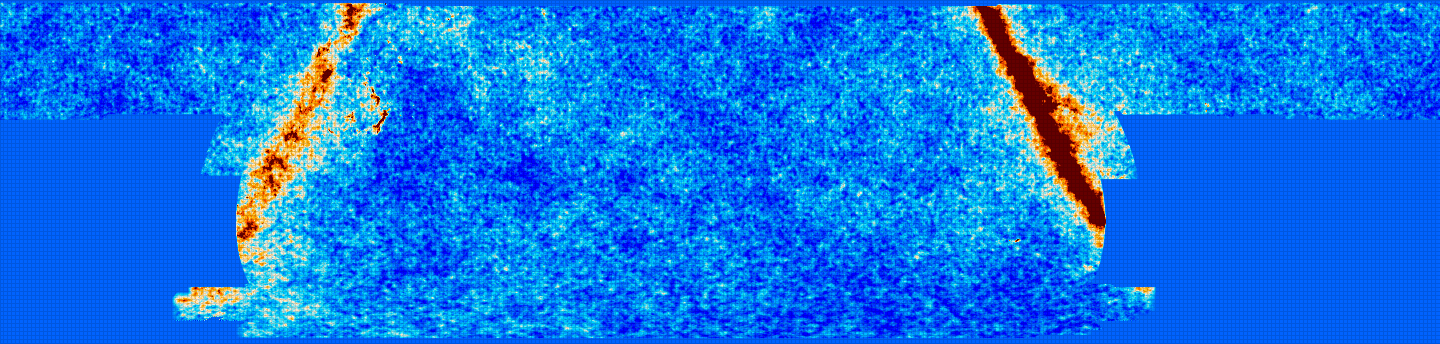

In [3]:
# Specifying 'download=True' will auto-download the ACT map if not already downloaded.
act_cmb = kszx.act.read_cmb(freq=150, dr=act_dr, download=True)
kszx.pixell_utils.plot_map(act_cmb, downgrade=30)

Reading /home/kmsmith/kszx_data/planck/release_2/ancillary-data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits (col_name='GAL070')


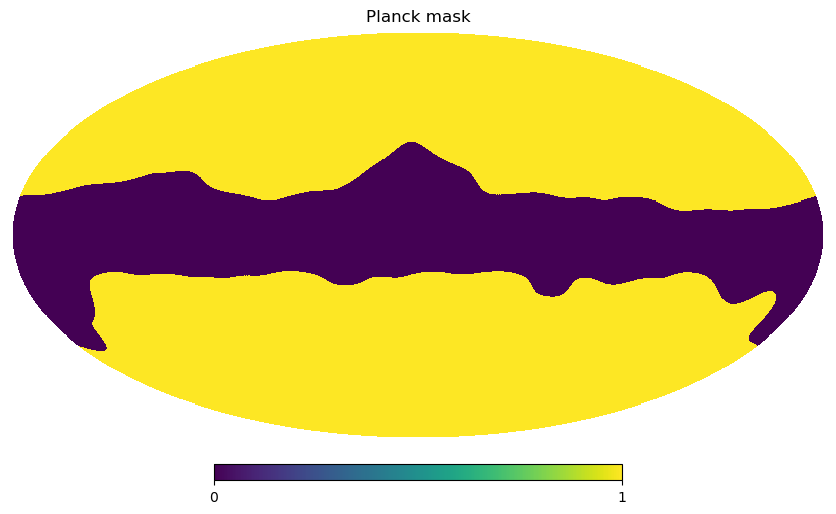

In [4]:
# Specifying 'download=True' will auto-download the Planck mask if not already downloaded.
healpix_mask = kszx.planck.read_hfi_galmask(
    sky_percentage = sky_percentage,
    apodization = apodization,
    download = True
)

healpy.mollview(healpix_mask, title='Planck mask')

## Convert mask from healpix to pixell

This one-liner converts the Planck healpix mask from healpix to pixell, and also rotates from galactic to equatorial coordinates (`rot='gal,equ'`).

This step takes a minute or so.

Reference: https://github.com/alexlague/kSZquest/blob/main/prepare_mask.py

In [5]:
%%time

pixell_mask = pixell.reproject.healpix2map(
    healpix_mask, 
    act_cmb.shape, 
    act_cmb.wcs, 
    rot='gal,equ', 
    method="spline", 
    order=0
)

CPU times: user 49.7 s, sys: 184 ms, total: 49.8 s
Wall time: 49.9 s


## Victory plot 1

Let's verify that it worked, by plotting the mask in the ACT coordinate system. Comparing to the plot above, you can see that it aligns well with the Galactic plane in the ACT data.

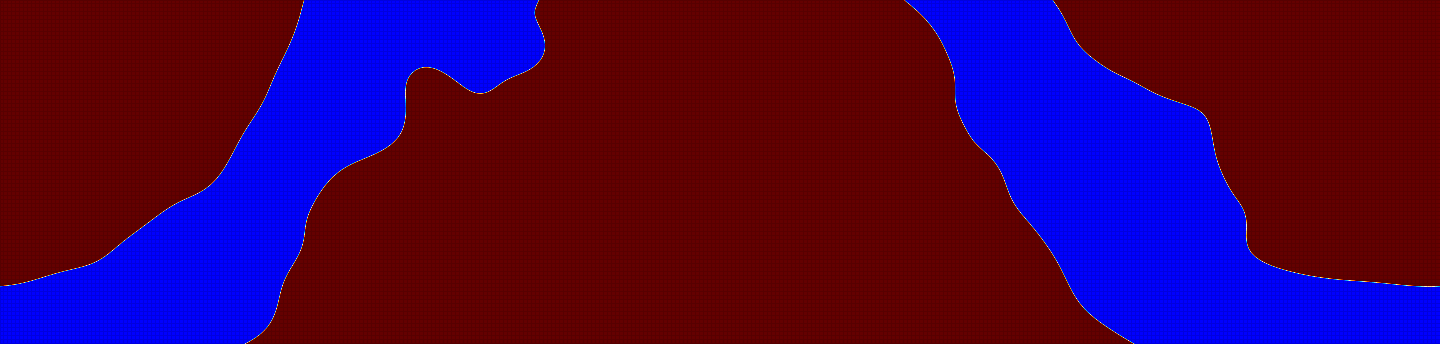

In [6]:
kszx.pixell_utils.plot_map(pixell_mask, downgrade=30)

## Victory plot 2

Let's plot the ACT data with the (pixellized) Planck mask applied. You can see that it does a good job of removing Galactic foregrounds, although a little bit of contamination is visible at the edges of the mask.

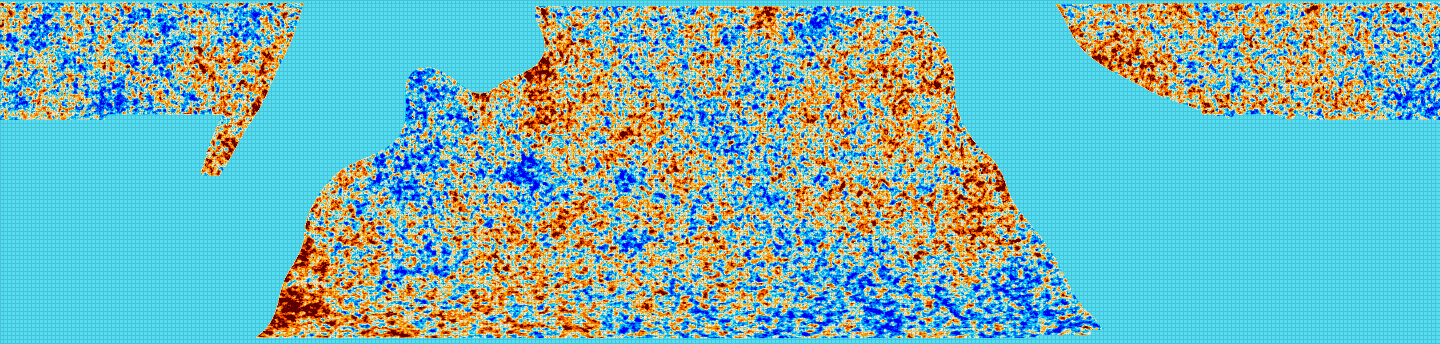

In [7]:
kszx.pixell_utils.plot_map(pixell_mask*act_cmb, downgrade=30)

## Save pixellized mask to disk, for use in later pipeline stages

In [8]:
kszx.pixell_utils.write_map('pixell_galmask.fits', pixell_mask)

Writing pixell_galmask.fits
